In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn.linear_model as skl_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'svg',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [2]:
df = pd.read_csv('Data/Advertising.csv', usecols=[1,2,3,4])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB


### Figure 3.1

(0, 30.0)

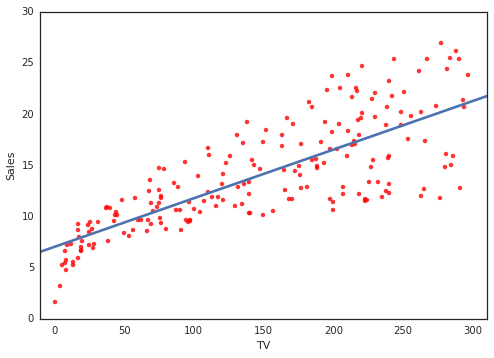

In [3]:
sns.regplot(df.TV, df.Sales, order=1, ci=None, scatter_kws={'color':'r'})
plt.xlim(-10,310)
plt.ylim(ymin=0)

### Figure 3.2

In [376]:
B0 = np.linspace(5, 9, 50)
B1 = np.linspace(0.02, 0.07, 50)
X, Y = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((50,50))

# Regression coefficients and corresponding RSS
regr = skl_lm.LinearRegression()
regr.fit(df[['TV']].as_matrix(), df.Sales.as_matrix().reshape(-1,1))
print(regr.intercept_)
print(regr.coef_)

[ 7.03259355]
[[ 0.04753664]]


In [377]:
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((df.Sales - (X[i,j]+df.TV*Y[i,j]))**2).sum()/1000

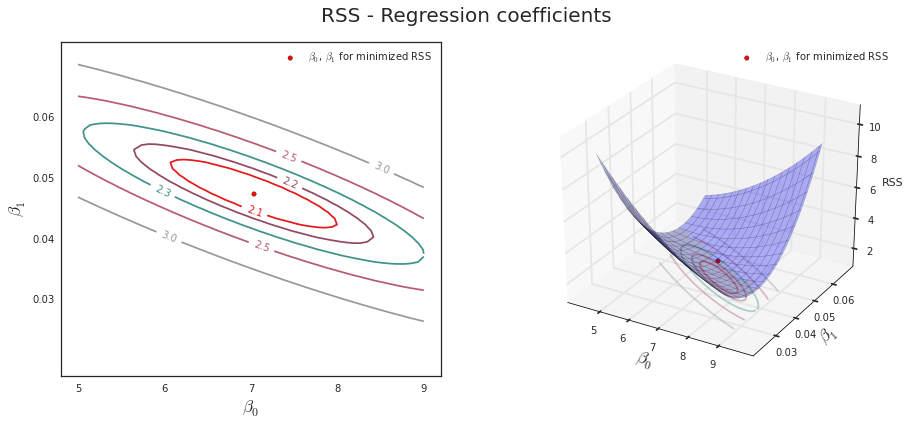

In [380]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X, Y, Z, cmap=cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_[0], regr.coef_[0,0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(X, Y, Z, zdir='z', offset=1, cmap=cm.Set1, alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(7.03, 0.0475, 2.1025452924375005, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(1,11)
ax2.set_xlim(4,10)
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_xticks([5,6,7,8,9])
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 (Statsmodels) 

In [97]:
est = smf.ols('df.Sales ~ df.TV', df).fit()
est.summary()§

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               df.Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Tue, 09 Jun 2015   Prob (F-statistic):           1.47e-42
Time:                        20:56:31   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000         6.130     7.935
df.TV          0.0475      0.003     17.668      0.000         0.042     0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
# RSS with regression coefficients
((df.Sales - (7.03 + 0.0475*df.TV))**2).sum()/1000

2.1025452924375005

### Table 3.1 & 3.2 (Scikit-learn)

In [144]:
regr = skl_lm.LinearRegression()
regr.fit(df.TV.as_matrix().reshape(-1,1), df.Sales.as_matrix().reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [145]:
print(regr.intercept_)
print(regr.coef_)

[ 7.03259355]
[[ 0.04753664]]


$$\beta_0 = 7.0326$$
$$\beta_1 = 0.0475$$

In [104]:
Sales_pred = regr.predict(df.TV.reshape(df.TV.size,1))

In [109]:
skl.metrics.r2_score(df.Sales.reshape(df.Sales.size,1), Sales_pred)

0.61187505085007099

$$R^2 = 0.612$$

### Table 3.3 (Statsmodels)

In [113]:
est = smf.ols('df.Sales ~ df.Radio', df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               df.Sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Tue, 09 Jun 2015   Prob (F-statistic):           4.35e-19
Time:                        21:16:00   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.000         8.202    10.422
df.Radio       0.2025      0.020      9.921      0.000         0.162     0.243
==============================================================================
Omnibus:                       19.358   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.910
Skew:                          -0.764   Prob(JB):                     1.75e-05
Kurtosis:                       3.544   Cond. No.                         51.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
est = smf.ols('df.Sales ~ df.Newspaper', df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               df.Sales   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.89
Date:                Tue, 09 Jun 2015   Prob (F-statistic):            0.00115
Time:                        21:16:43   Log-Likelihood:                -608.34
No. Observations:                 200   AIC:                             1221.
Df Residuals:                     198   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       12.3514      0.621     19.876      0.000        11.126    13.577
df.Newspaper     0.0547      0.017      3.300      0.001         0.022     0.087
==============================================================================
Omnibus:                        6.231   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.483
Skew:                           0.330   Prob(JB):                       0.0645
Kurtosis:                       2.527   Cond. No.                         64.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.4 & 3.6 (Statsmodels)

In [59]:
est = smf.ols('df.Sales ~ df.TV + df.Radio + df.Newspaper', df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               df.Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 02 Jun 2015   Prob (F-statistic):           1.58e-96
Time:                        22:32:26   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        2.9389      0.312      9.422      0.000         2.324     3.554
df.TV            0.0458      0.001     32.809      0.000         0.043     0.049
df.Radio         0.1885      0.009     21.893      0.000         0.172     0.206
df.Newspaper    -0.0010      0.006     -0.177      0.860        -0.013     0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.5

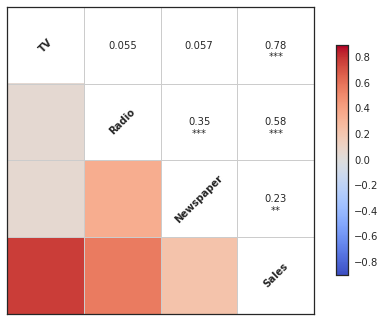

In [285]:
sns.corrplot(df)

### Figure 3.5

In [335]:
regr = skl_lm.LinearRegression()
regr.fit(df[['Radio', 'TV']].as_matrix(), df.Sales.as_matrix().reshape(-1,1))
print(regr.coef_)
print(regr.intercept_)

[[ 0.18799423  0.04575482]]
[ 2.92109991]


In [349]:
# What are the min/max values of Radio & TV?
df[['Radio', 'TV']].describe()

            Radio          TV
count  200.000000  200.000000
mean    23.264000  147.042500
std     14.846809   85.854236
min      0.000000    0.700000
25%      9.975000   74.375000
50%     22.900000  149.750000
75%     36.525000  218.825000
max     49.600000  296.400000

In [337]:
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((300,50))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_[0] + B1[i,j]*regr.coef_[0,0] + B2[i,j]*regr.coef_[0,1])

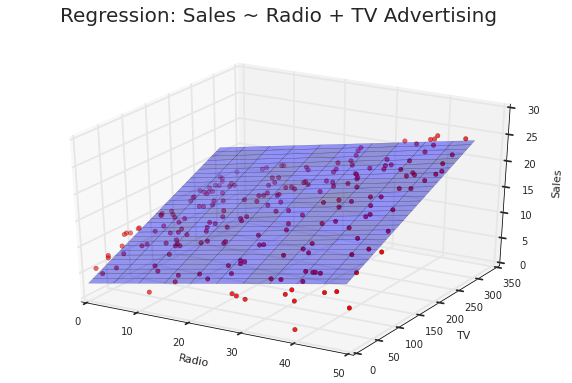

In [344]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax1 = fig.add_subplot(111, projection='3d')

ax1.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax1.scatter3D(df.Radio, df.TV, df.Sales, c='r')

ax1.set_xlabel('Radio')
ax1.set_xlim(0,50)
ax1.set_ylabel('TV')
ax1.set_ylim(ymin=0)
ax1.set_zlabel('Sales')

### Figure 3.6

In [14]:
df2 = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
df2['Student2'] = df2.Student.map({'No':0, 'Yes':1})
df2.head(3)

    Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  Student2  
0  Caucasian      333         0  
1      Asian      903         1  
2      Asian      580         0  

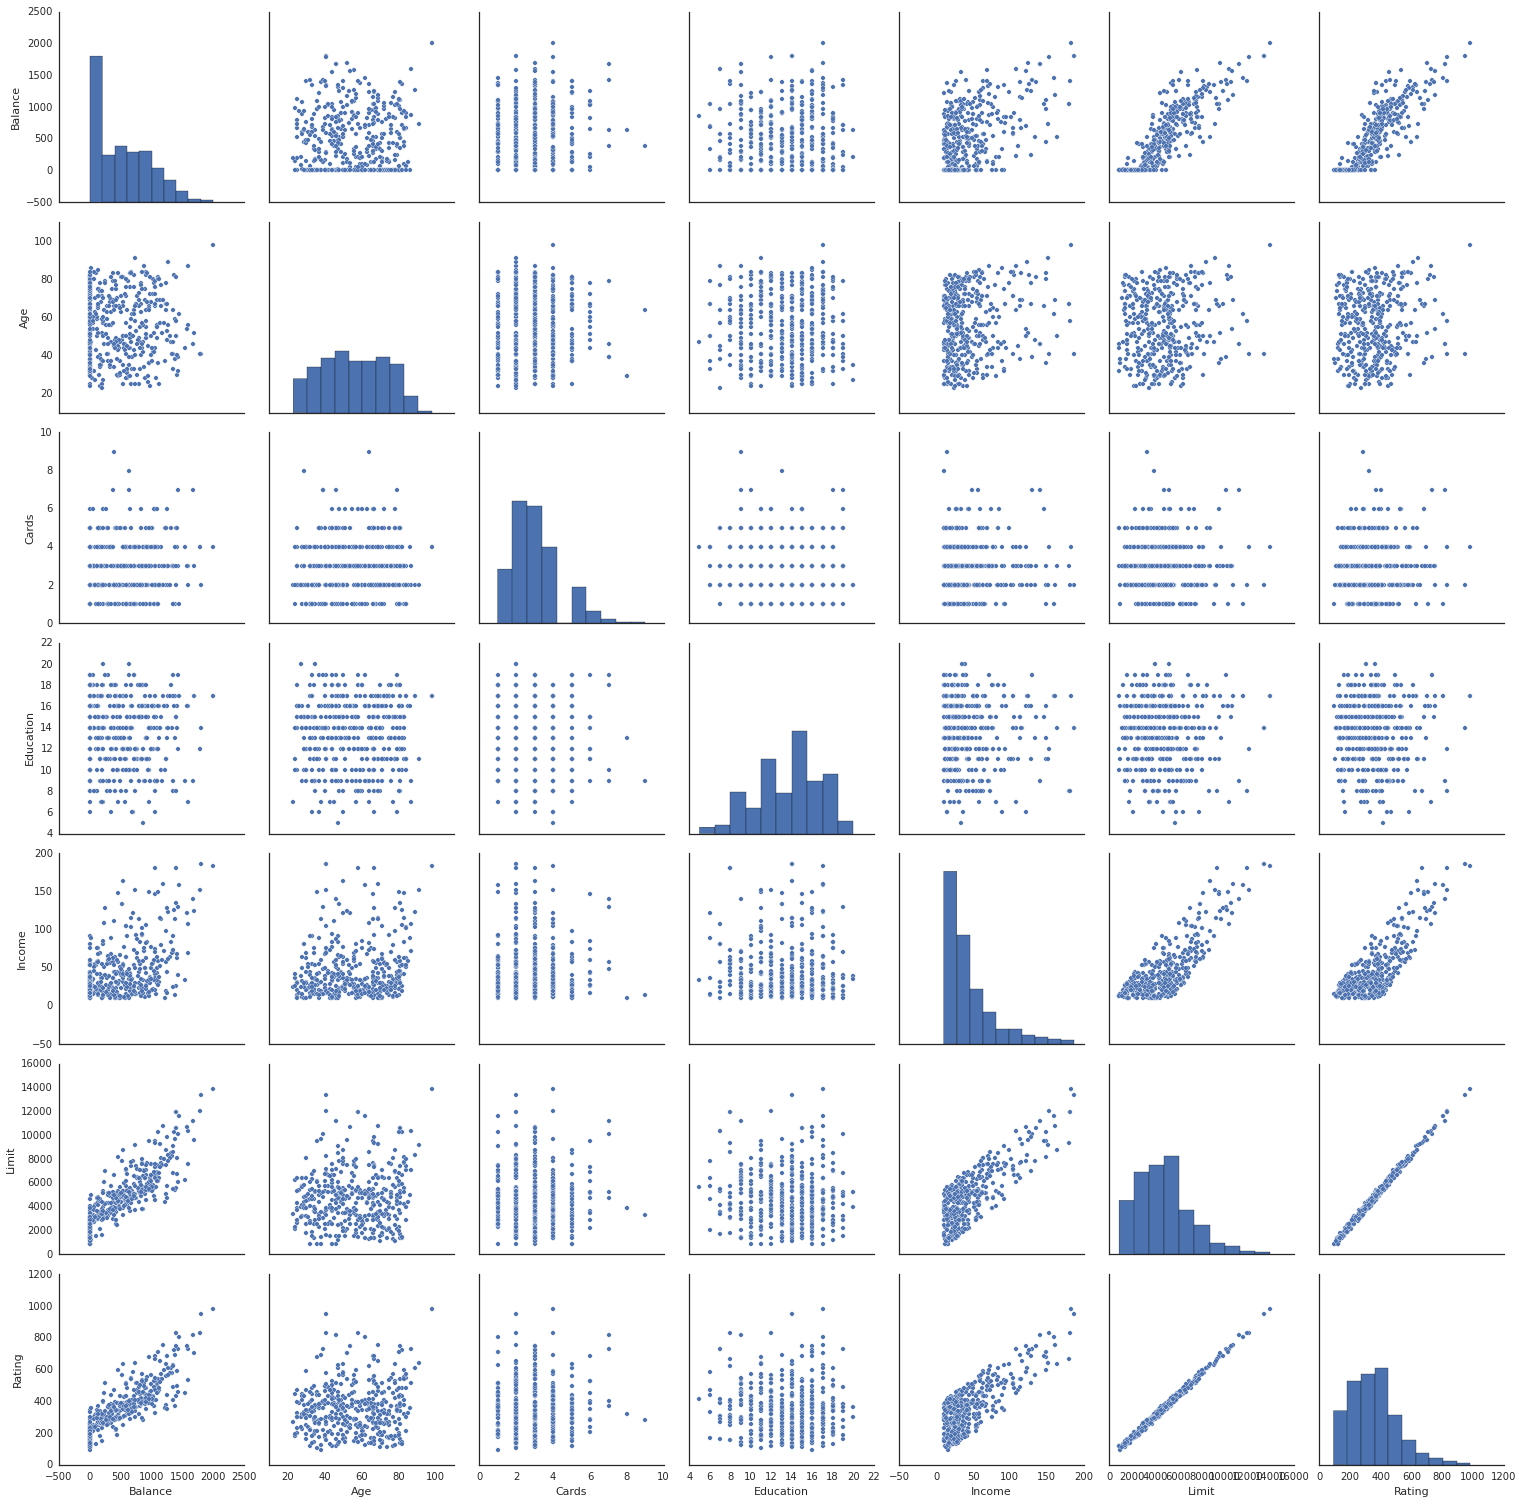

In [7]:
sns.pairplot(df2[['Balance','Age','Cards','Education','Income','Limit','Rating']])

###  Table 3.7

In [405]:
est = smf.ols('df2.Balance ~ df2.Gender', df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             df.Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1836
Date:                Thu, 11 Jun 2015   Prob (F-statistic):              0.669
Time:                        06:45:40   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             509.8031     33.128     15.389      0.000       444.675   574.931
df.Gender[T.Female]    19.7331     46.051      0.429      0.669       -70.801   110.267
==============================================================================
Omnibus:                       28.438   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.346
Skew:                           0.583   Prob(JB):                     1.15e-06
Kurtosis:                       2.471   Cond. No.                         2.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.8

In [48]:
est = smf.ols('df2.Balance ~ df2.Ethnicity', df2).fit()
est.summary()

Intercept                     531.000000
df2.Ethnicity[T.Asian]        -18.686275
df2.Ethnicity[T.Caucasian]    -12.502513
dtype: float64

### Table 3.9

In [412]:
est = smf.ols('df.Sales ~ df.TV + df.Radio + df.TV*df.Radio', df).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               df.Sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Thu, 11 Jun 2015   Prob (F-statistic):          6.68e-146
Time:                        06:51:18   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.7502      0.248     27.233      0.000         6.261     7.239
df.TV              0.0191      0.002     12.699      0.000         0.016     0.022
df.Radio           0.0289      0.009      3.241      0.001         0.011     0.046
df.TV:df.Radio     0.0011   5.24e-05     20.727      0.000         0.001     0.001
==============================================================================
Omnibus:                      128.132   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.719
Skew:                          -2.323   Prob(JB):                    9.09e-258
Kurtosis:                      13.975   Cond. No.                     1.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Figure 3.7

In [64]:
est1 = smf.ols('df2.Balance ~ df2.Income + df2.Student2', df2).fit()
regr1 = est1.params
est2 = smf.ols('df2.Balance ~ df2.Income + df2.Income*df2.Student2', df2).fit()
regr2 = est2.params

print('Regression 1')
print(regr1)
print('\nRegression 2')
print(regr2)

Regression 1
Intercept       211.142964
df2.Income        5.984336
df2.Student2    382.670539
dtype: float64

Regression 2
Intercept                  200.623153
df2.Income                   6.218169
df2.Student2               476.675843
df2.Income:df2.Student2     -1.999151
dtype: float64


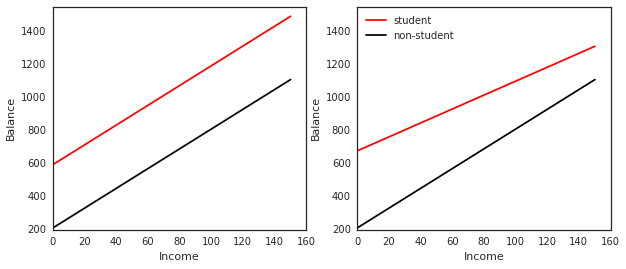

In [68]:
income = np.linspace(0,150)
student1 = np.linspace(regr1['Intercept']+regr1['df2.Student2'],
                       regr1['Intercept']+regr1['df2.Student2']+150*+regr1['df2.Income'])
student2 = np.linspace(regr2['Intercept']+regr2['df2.Student2'],
                       regr2['Intercept']+regr2['df2.Student2']+150*(regr2['df2.Income']+regr2['df2.Income:df2.Student2']))
non_student =  np.linspace(regr.intercept_, 150*regr.coef_[0,0]+regr.intercept_)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(income, student1, 'r', income, non_student, 'k')
ax2.plot(income, student2, 'r', income, non_student, 'k')
ax2.legend(['student', 'non-student'], loc=2)

for ax in fig.axes:
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8

In [184]:
df3 = pd.read_csv('Data/Auto.csv', na_values='?').dropna()

In [185]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 29.1+ KB


In [186]:
df3['horsepower2'] = df3.horsepower**2
df3.head(3)

   mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0   18          8           307         130    3504          12.0    70   
1   15          8           350         165    3693          11.5    70   
2   18          8           318         150    3436          11.0    70   

   origin                       name  horsepower2  
0       1  chevrolet chevelle malibu        16900  
1       1          buick skylark 320        27225  
2       1         plymouth satellite        22500  

(40, 240)

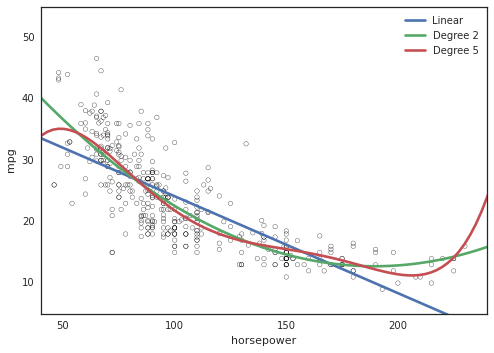

In [187]:
plt.scatter(df3.horsepower, df3.mpg, facecolor='None', edgecolor='k') 
sns.regplot(df3.horsepower, df3.mpg, ci=None, label='Linear', scatter=False)
sns.regplot(df3.horsepower, df3.mpg, ci=None, label='Degree 2', order=2, scatter=False)
sns.regplot(df3.horsepower, df3.mpg, ci=None, label='Degree 5', order=5, scatter=False)
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240)

### Table 3.10

In [188]:
est = smf.ols('df3.mpg ~ df3.horsepower + df3.horsepower2', df3).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                df3.mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Sat, 13 Jun 2015   Prob (F-statistic):           5.40e-99
Time:                        20:43:16   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          56.9001      1.800     31.604      0.000        53.360    60.440
df3.horsepower     -0.4662      0.031    -14.978      0.000        -0.527    -0.405
df3.horsepower2     0.0012      0.000     10.080      0.000         0.001     0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Figure 3.14

In [221]:
regr1 = skl_lm.LinearRegression()
regr1.fit(df3.horsepower.as_matrix().reshape(-1,1), df3.mpg.as_matrix().reshape(-1,1))
df3['pred1'] = regr1.predict(df3.horsepower.as_matrix().reshape(-1,1))
df3['resid1'] = df3.mpg - df3.pred1

regr2 = skl_lm.LinearRegression()
regr2.fit(df3[['horsepower', 'horsepower2']].as_matrix().reshape(-1,2), df3.mpg.as_matrix().reshape(-1,1))
df3['pred2'] = regr2.predict(df3[['horsepower', 'horsepower2']].as_matrix().reshape(-1,2))
df3['resid2'] = df3.mpg - df3.pred2

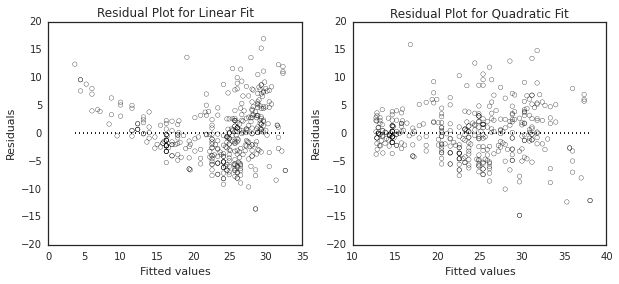

In [247]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.scatter(df3.pred1, df3.resid1, facecolor='None', edgecolor='k')
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0], xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

ax2.scatter(df3.pred2, df3.resid2, facecolor='None', edgecolor='k')
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0], xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')    

### Figure 3.14

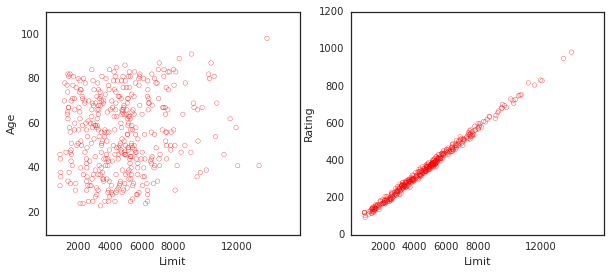

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.scatter(df2.Limit, df2.Age, facecolor='None', edgecbolor='r')
ax1.set_ylabel('Age')
ax2.scatter(df2.Limit, df2.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [53]:
df2.describe()

           Income         Limit      Rating       Cards         Age  \
count  400.000000    400.000000  400.000000  400.000000  400.000000   
mean    45.218885   4735.600000  354.940000    2.957500   55.667500   
std     35.244273   2308.198848  154.724143    1.371275   17.249807   
min     10.354000    855.000000   93.000000    1.000000   23.000000   
25%     21.007250   3088.000000  247.250000    2.000000   41.750000   
50%     33.115500   4622.500000  344.000000    3.000000   56.000000   
75%     57.470750   5872.750000  437.250000    4.000000   70.000000   
max    186.634000  13913.000000  982.000000    9.000000   98.000000   

        Education      Balance    Student2  
count  400.000000   400.000000  400.000000  
mean    13.450000   520.015000    0.100000  
std      3.125207   459.758877    0.300376  
min      5.000000     0.000000    0.000000  
25%     11.000000    68.750000    0.000000  
50%     14.000000   459.500000    0.000000  
75%     16.000000   863.000000    0.000000  


In [60]:
B_Limit = np.linspace(0.15, 0.19, 50)
B_Age = np.linspace(-5, 0, 50)
X, Y = np.meshgrid(B_Limit, B_Age, indexing='xy')
Z = np.zeros((50,50))

In [56]:
# Regression coefficients and corresponding RSS
regr = skl_lm.LinearRegression()
regr.fit(df2[['Age', 'Limit']].as_matrix(), df2.Balance.as_matrix().reshape(-1,1))
print(regr.intercept_)
print(regr.coef_)

[-173.4109014]
[[-2.29148553  0.17336497]]


In [70]:
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((df2.Balance - (regr.intercept_ + X[i,j]*df2.Limit+Y[i,j]*df2.Age))**2).sum()/1000000

<a list of 0 text.Text objects>

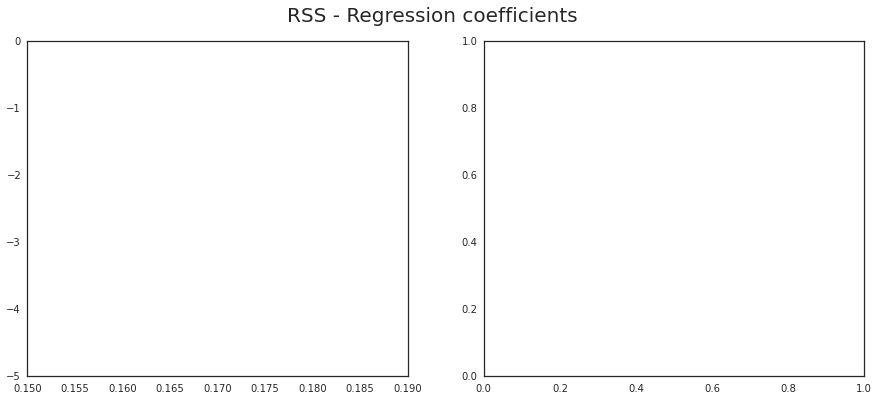

In [71]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X, Y, Z, cmap=cm.Set1, levels=[21.25, 21.5, 21.8])
#ax1.scatter(regr.intercept_[0], regr.coef_[0,0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')


# Right plot
#ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, alpha=0.3)
#ax2.contour(X, Y, Z, zdir='z', offset=1, cmap=cm.Set1, alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
#ax2.scatter3D(7.03, 0.0475, 2.1025452924375005, c='r', label=min_RSS)
#ax2.set_zlabel('RSS')
#ax2.set_zlim(1,11)
#ax2.set_xlim(4,10)
#ax2.set_ylim(0.02,0.07)

# settings common to both plots
#for ax in fig.axes:
#    ax.set_xlabel(r'$\beta_0$', fontsize=17)
#    ax.set_xticks([5,6,7,8,9])
#    ax.set_ylabel(r'$\beta_1$', fontsize=17)
#    ax.set_yticks([0.03,0.04,0.05,0.06])
#    ax.legend()

### Variance Inflation Factor (page 102)

In [28]:
est_Age = smf.ols('df2.Age ~ df2.Rating + df2.Limit', df2).fit()
est_Rating = smf.ols('df2.Rating ~ df2.Age + df2.Limit', df2).fit()
est_Limit = smf.ols('df2.Limit ~ df2.Age + df2.Rating', df2).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))

1.01138468607
160.668300959
160.592879786
